# Imports

In [31]:
import pandas as pd # To work with dataset
import numpy as np # To do some math
import matplotlib.pyplot as plt # To plot the data
from sklearn.preprocessing import MinMaxScaler # To scale the data
from datetime import timedelta # To do some time calculations
from statsmodels.tsa.stattools import acf # To plot autocorrelations
import pmdarima as pm # To find the best ARIMA model
from sklearn.linear_model import LassoCV # To choose the best alpha
from sklearn.linear_model import Lasso # To build the Lasso Model
import statsmodels.api as sm # To build the final model

# Data Inspection/Manipulation

In [32]:
# Set the location of the data
production_data_loc = "data/production.csv"
weather_data_loc = "data/processed_weather.csv"

In [33]:
# Load the production data
production_df = pd.read_csv(production_data_loc)
production_df["date"] = pd.to_datetime(production_df["date"])
production_df = production_df.iloc[4:] # Remove the first 4 rows which are not in weather data
production_df = production_df.drop_duplicates() # Remove duplicates
production_df.reset_index(drop=True, inplace=True) # Reset the index
production_df["production"] = production_df["production"].apply(lambda x: 10 if x > 10 else x) # Set the maximum production to 10

production_df

,date,hour,production
0,2022-01-01,4,0.0
1,2022-01-01,5,0.0
2,2022-01-01,6,0.0
3,2022-01-01,7,0.0
4,2022-01-01,8,3.4
...,...,...,...
20967,2024-05-23,19,0.0
20968,2024-05-23,20,0.0
20969,2024-05-23,21,0.0
20970,2024-05-23,22,0.0


In [34]:
# Load the weather data
weather_df = pd.read_csv(weather_data_loc) 
weather_df["date"] = pd.to_datetime(weather_df["date"], format='%Y-%m-%d') # Convert the date to datetime
weather_df = weather_df.sort_values(by=['date', 'hour']) # Sort the data by date and hour
weather_df.reset_index(drop=True, inplace=True) # Reset the index

weather_df

,date,hour,lat,lon,dswrf_surface,tcdc_low.cloud.layer,tcdc_middle.cloud.layer,tcdc_high.cloud.layer,tcdc_entire.atmosphere,uswrf_top_of_atmosphere,csnow_surface,dlwrf_surface,uswrf_surface,tmp_surface
0,2022-01-01,4,38.00,34.75,0.000,3.0,5.0,7.2,15.1,0.000,0.0,225.079,0.000,269.004
1,2022-01-01,4,38.75,35.50,0.000,1.4,0.1,5.0,6.7,0.000,0.0,232.479,0.000,271.204
2,2022-01-01,4,38.00,35.25,0.000,0.0,5.1,4.1,10.6,0.000,0.0,209.479,0.000,265.004
3,2022-01-01,4,38.50,34.75,0.000,3.0,0.0,5.0,11.4,0.000,0.0,229.579,0.000,270.804
4,2022-01-01,4,38.75,34.50,0.000,5.0,0.0,5.0,14.7,0.000,0.0,241.779,0.000,271.404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527245,2024-05-28,21,38.25,34.50,278.144,51.4,6.1,0.0,52.2,145.312,0.0,314.501,54.592,283.700
527246,2024-05-28,21,38.00,34.75,340.848,0.7,0.0,0.0,0.7,101.184,0.0,293.701,69.440,284.700
527247,2024-05-28,21,38.75,34.75,284.224,18.1,0.0,0.7,19.2,140.672,0.0,330.601,61.568,287.400
527248,2024-05-28,21,38.25,35.25,290.560,35.1,1.1,0.0,35.6,128.304,0.0,326.601,61.632,288.300


In [35]:
# Pivot the weather data
columns_to_pivot = weather_df.columns[4:] # Get the columns to pivot

for col in columns_to_pivot:
    weather_df[f'{col}_identifier'] = col + "_" + weather_df['lat'].astype(str) + "_" + weather_df['lon'].astype(str)

pivoted_dfs = []
for col in columns_to_pivot:
    pivoted_df = pd.pivot(
        weather_df,
        index=['date', 'hour'],
        columns=f'{col}_identifier',
        values=col
    )
    pivoted_df.columns.name = None 
    pivoted_df.reset_index(inplace=True)  
    pivoted_dfs.append(pivoted_df)

result_df = pivoted_dfs[0]
for df in pivoted_dfs[1:]:
    result_df = result_df.merge(df, on=['date', 'hour'], how='outer') 
    
df = result_df.iloc[:, :252] # Remove the identifier columns

df

,date,hour,dswrf_surface_37.75_34.5,dswrf_surface_37.75_34.75,dswrf_surface_37.75_35.0,dswrf_surface_37.75_35.25,dswrf_surface_37.75_35.5,dswrf_surface_38.0_34.5,dswrf_surface_38.0_34.75,dswrf_surface_38.0_35.0,...,tmp_surface_38.5_34.5,tmp_surface_38.5_34.75,tmp_surface_38.5_35.0,tmp_surface_38.5_35.25,tmp_surface_38.5_35.5,tmp_surface_38.75_34.5,tmp_surface_38.75_34.75,tmp_surface_38.75_35.0,tmp_surface_38.75_35.25,tmp_surface_38.75_35.5
0,2022-01-01,4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,271.404,270.804,270.504,271.204,262.204,271.404,271.404,270.904,270.304,271.204
1,2022-01-01,5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,271.304,270.804,270.604,271.104,262.004,271.304,271.204,270.804,270.104,271.104
2,2022-01-01,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,271.331,270.831,270.531,270.931,262.031,271.231,271.131,270.731,270.031,271.131
3,2022-01-01,7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,271.217,270.817,270.517,270.917,262.317,271.217,271.117,270.717,270.017,271.217
4,2022-01-01,8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,271.194,270.894,270.594,270.894,263.394,271.194,271.094,270.594,269.894,270.994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21085,2024-05-28,17,669.480,681.480,691.380,569.620,489.000,699.540,697.620,692.880,...,294.225,292.725,296.525,292.825,289.125,296.725,297.825,296.925,296.725,297.025
21086,2024-05-28,18,582.380,582.560,596.280,511.620,438.240,604.260,602.320,598.100,...,293.000,291.500,292.100,292.200,288.300,294.500,294.200,293.100,293.700,294.200
21087,2024-05-28,19,487.648,487.184,496.464,422.736,361.488,503.520,502.560,498.960,...,290.453,289.553,289.553,288.753,285.953,292.053,291.753,290.453,290.153,290.153
21088,2024-05-28,20,397.200,396.592,403.648,343.472,293.616,409.856,409.008,405.776,...,286.100,285.800,286.300,285.700,282.200,288.500,288.100,288.200,289.900,286.800


## bunu sil sonra

In [36]:
date = pd.to_datetime("2024-05-12")
df = df[df["date"] != date]
production_df = production_df[production_df["date"] != date]

In [37]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 10)) # Scale the data between 0 and 10

columns_to_scale = df.columns[2:] # Do not scale the date and hour columns

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

/var/folders/mk/yzmswp8x76g_k99y3jccgr0c0000gn/T/ipykernel_1834/3989266483.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


In [38]:
# Get the data that matches with the production data
end_date = production_df["date"].iloc[-1]
end_hour = production_df["hour"].iloc[-1]

predict_df = df.copy() # To keep the original data and use it later

cut_off_index = df[(df["date"] == end_date) & (df["hour"] == end_hour)].index.min() 
df = df.loc[:cut_off_index]
df = pd.merge(df, production_df, on=["date", "hour"], how = "inner")
df.fillna(method='ffill', inplace=True)

df

/var/folders/mk/yzmswp8x76g_k99y3jccgr0c0000gn/T/ipykernel_1834/3183546143.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,date,hour,dswrf_surface_37.75_34.5,dswrf_surface_37.75_34.75,dswrf_surface_37.75_35.0,dswrf_surface_37.75_35.25,dswrf_surface_37.75_35.5,dswrf_surface_38.0_34.5,dswrf_surface_38.0_34.75,dswrf_surface_38.0_35.0,...,tmp_surface_38.5_34.75,tmp_surface_38.5_35.0,tmp_surface_38.5_35.25,tmp_surface_38.5_35.5,tmp_surface_38.75_34.5,tmp_surface_38.75_34.75,tmp_surface_38.75_35.0,tmp_surface_38.75_35.25,tmp_surface_38.75_35.5,production
0,2022-01-01,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.792751,2.563750,2.560073,2.381561,2.866957,2.738521,2.454569,2.315101,2.207942,0.0
1,2022-01-01,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.792751,2.576989,2.546334,2.355981,2.854968,2.714355,2.441626,2.290149,2.194867,0.0
2,2022-01-01,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.796341,2.567324,2.522566,2.359434,2.846216,2.705534,2.432177,2.281041,2.198397,0.0
3,2022-01-01,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.794479,2.565471,2.520642,2.396015,2.844537,2.703842,2.430365,2.279294,2.209641,0.0
4,2022-01-01,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.804718,2.575665,2.517483,2.533766,2.841780,2.701063,2.414445,2.263948,2.180485,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20943,2024-05-23,19,4.417397,4.350159,4.862816,4.725335,3.333375,4.279121,4.806142,5.068056,...,5.133561,5.291805,5.308503,5.566996,4.941673,5.192001,5.471007,5.372417,5.294248,0.0
20944,2024-05-23,20,3.590903,3.537817,3.940923,3.818174,2.711204,3.444363,3.881845,4.094146,...,4.959513,4.747782,5.032492,5.182134,5.060485,4.925085,4.680300,4.797385,4.900828,0.0
20945,2024-05-23,21,2.992419,2.948180,3.283965,3.181867,2.259280,2.870162,3.234871,3.411761,...,4.972809,4.747782,4.551637,5.220505,5.132420,4.985500,4.706187,4.497954,4.312462,0.0
20946,2024-05-23,22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.172253,4.840461,4.510421,5.182134,5.012529,4.888835,4.589697,4.473001,4.364761,0.0


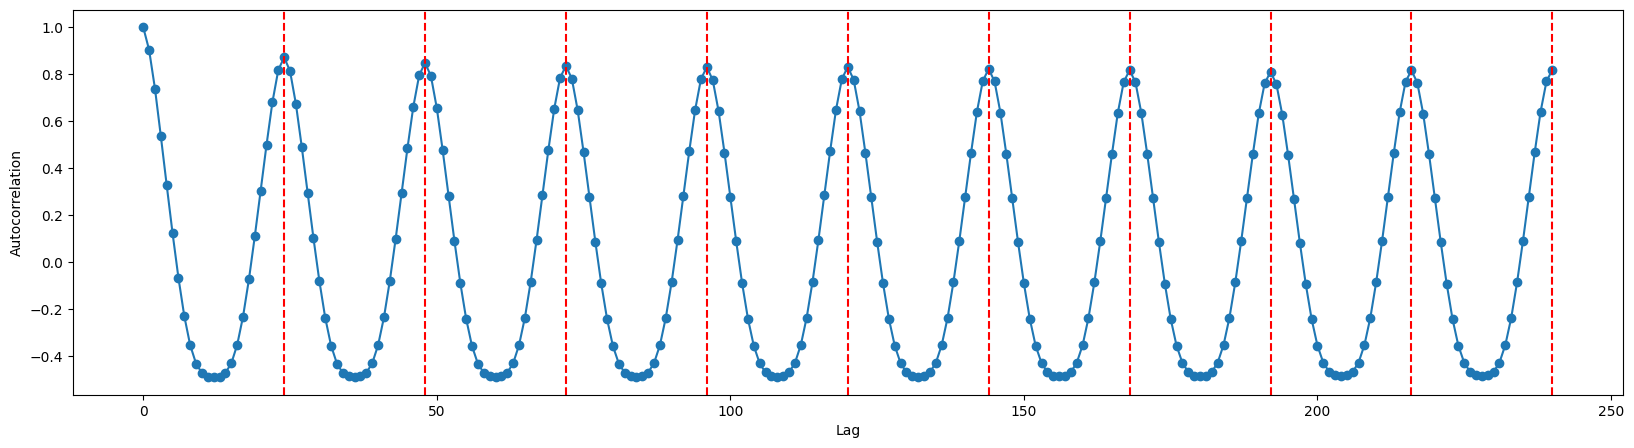

In [39]:
# Plot the autocorrelation of the production data
acf_values = acf(df["production"], nlags=24*10)
plt.figure(figsize=(20, 5))
plt.plot(range(len(acf_values)), acf_values, marker='o', linestyle='-')
for i in range(1, 11):
    plt.axvline(x=24*i, color='red', linestyle='--')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

# ARIMA

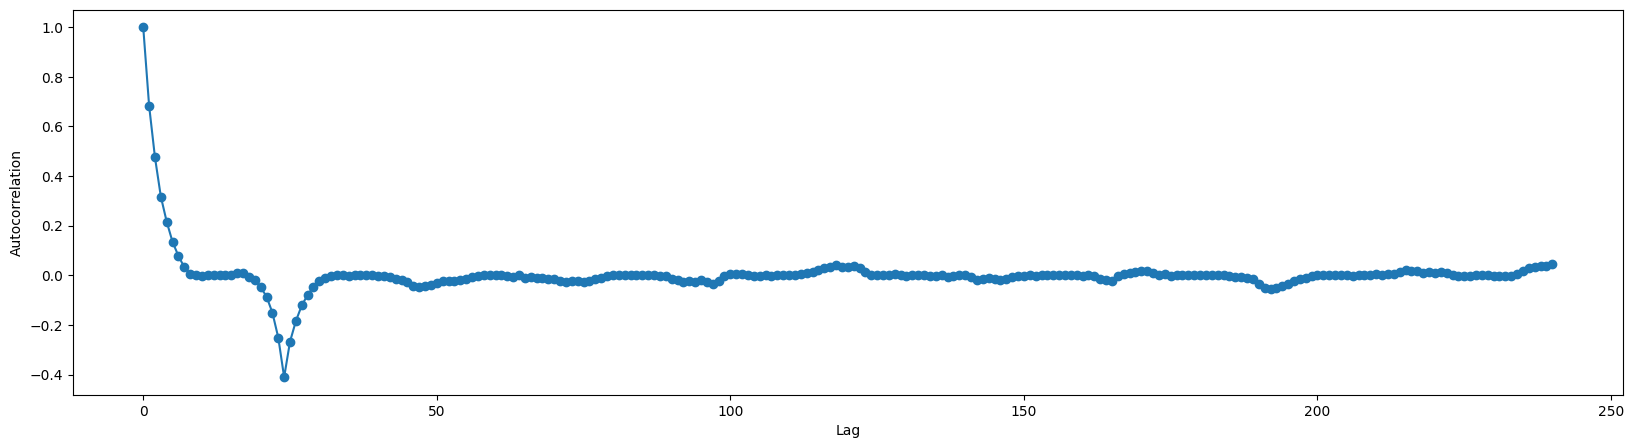

In [40]:
diff_24_production = [df["production"][i] - df["production"][i-24] for i in range(24, len(df["production"]))]

acf_values = acf(diff_24_production, nlags=24*10)
plt.figure(figsize=(20, 5))
plt.plot(range(len(acf_values)), acf_values, marker='o', linestyle='-')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

In [41]:
arima_model = pm.auto_arima(
    diff_24_production,
    start_d=0,
    max_d=1,
    seasonal=False,  
    stepwise=True,   
    trace=True,      
    error_action='ignore',  
    suppress_warnings=True, 
    max_order=10,     
    information_criterion='bic',  
)

best_arima = arima_model.fit(diff_24_production)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=71926.944, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=85097.952, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=71918.027, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=76346.630, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=71923.832, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=71924.100, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=71919.893, Time=1.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=71927.973, Time=0.42 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 3.969 seconds


In [42]:
best_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20924
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -35949.065
Date:                Sat, 01 Jun 2024   AIC                          71902.130
Time:                        17:05:16   BIC                          71918.027
Sample:                             0   HQIC                         71907.320
                              - 20924                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6838      0.003    256.567      0.000       0.679       0.689
sigma2         1.8189      0.008    240.772      0.000       1.804       1.834
===================================================================================
Ljung-Box (L1) (Q):                   1.93   Jarque-Bera (JB):             74463.97
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

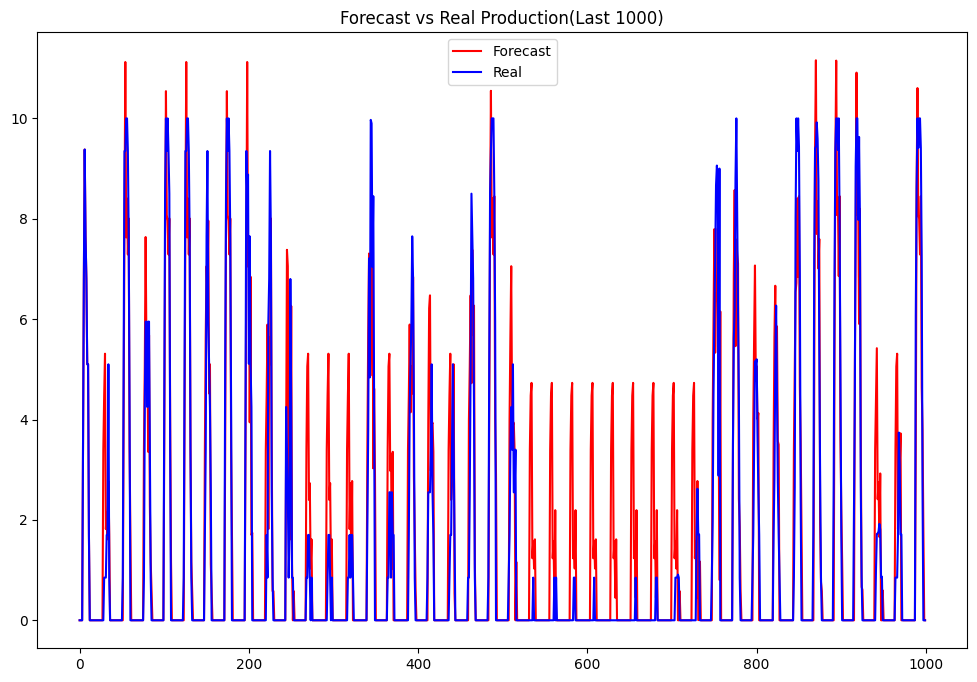

In [43]:
forecasted_values = list(df["production"][:24])

for diff in list(best_arima.fittedvalues()):
    new_value = forecasted_values[-24] + diff
    forecasted_values.append(new_value)

forecasted_values = [max(0, i) for i in forecasted_values]

plt.figure(figsize=(12, 8))
plt.plot(range(len(df["production"][:1000])),forecasted_values[:1000], label="Forecast", c = "red")
plt.plot(range(len(df["production"][:1000])),df["production"][:1000], label="Real", c="blue")
plt.title("Forecast vs Real Production(Last 1000)")
plt.legend(loc="best")
plt.show()

# Penalized Regression

In [44]:
features = df.copy()
features.drop(columns=["date", "hour", "production"], inplace=True)

lst = weather_df.columns[4:-10]

for feature in lst:
    feature_col = df.columns[df.columns.str.contains(feature)]
    features[f"max_{feature}"] = df[feature_col].max(axis=1)
    features[f"min_{feature}"] = df[feature_col].min(axis=1)
    features[f"mean_{feature}"] = df[feature_col].mean(axis=1)
    features[f"sum_{feature}"] = df[feature_col].sum(axis=1)
    features[f"median_{feature}"] = df[feature_col].median(axis=1)
    features[f"std_{feature}"] = df[feature_col].std(axis=1)
    features[f"var_{feature}"] = df[feature_col].var(axis=1)
    features[f"range_{feature}"] = df[feature_col].max(axis=1) - df[feature_col].min(axis=1)

features

,dswrf_surface_37.75_34.5,dswrf_surface_37.75_34.75,dswrf_surface_37.75_35.0,dswrf_surface_37.75_35.25,dswrf_surface_37.75_35.5,dswrf_surface_38.0_34.5,dswrf_surface_38.0_34.75,dswrf_surface_38.0_35.0,dswrf_surface_38.0_35.25,dswrf_surface_38.0_35.5,...,var_uswrf_surface,range_uswrf_surface,max_tmp_surface,min_tmp_surface,mean_tmp_surface,sum_tmp_surface,median_tmp_surface,std_tmp_surface,var_tmp_surface,range_tmp_surface
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.970018,1.938558,2.477303,61.932586,2.524168,0.283675,0.080472,1.031460
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.957112,1.909188,2.461961,61.549024,2.512177,0.287704,0.082774,1.047924
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.960597,1.883783,2.452826,61.320651,2.487963,0.290394,0.084329,1.076813
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.945884,1.881728,2.448251,61.206282,2.472008,0.287081,0.082416,1.064156
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.942915,1.863665,2.448233,61.205814,2.486316,0.291087,0.084732,1.079250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20943,4.417397,4.350159,4.862816,4.725335,3.333375,4.279121,4.806142,5.068056,4.450029,4.830602,...,0.111908,1.151504,5.692908,4.556321,5.291818,132.295448,5.294248,0.263889,0.069638,1.136588
20944,3.590903,3.537817,3.940923,3.818174,2.711204,3.444363,3.881845,4.094146,3.609129,3.911386,...,0.074970,0.950642,5.255237,4.522519,4.937514,123.437858,4.915365,0.174438,0.030428,0.732718
20945,2.992419,2.948180,3.283965,3.181867,2.259280,2.870162,3.234871,3.411761,3.007663,3.259600,...,0.052065,0.792193,5.220505,4.312462,4.840934,121.023357,4.799483,0.245668,0.060353,0.908044
20946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.189401,4.364761,4.795418,119.885444,4.834985,0.239255,0.057243,0.824640


In [45]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(features, df["production"])

optimal_lambda = lasso_cv.alpha_

optimal_lambda

0.1604038979358355

In [46]:
lasso = Lasso(optimal_lambda)

lasso.fit(features, df["production"])

Lasso(alpha=0.1604038979358355)

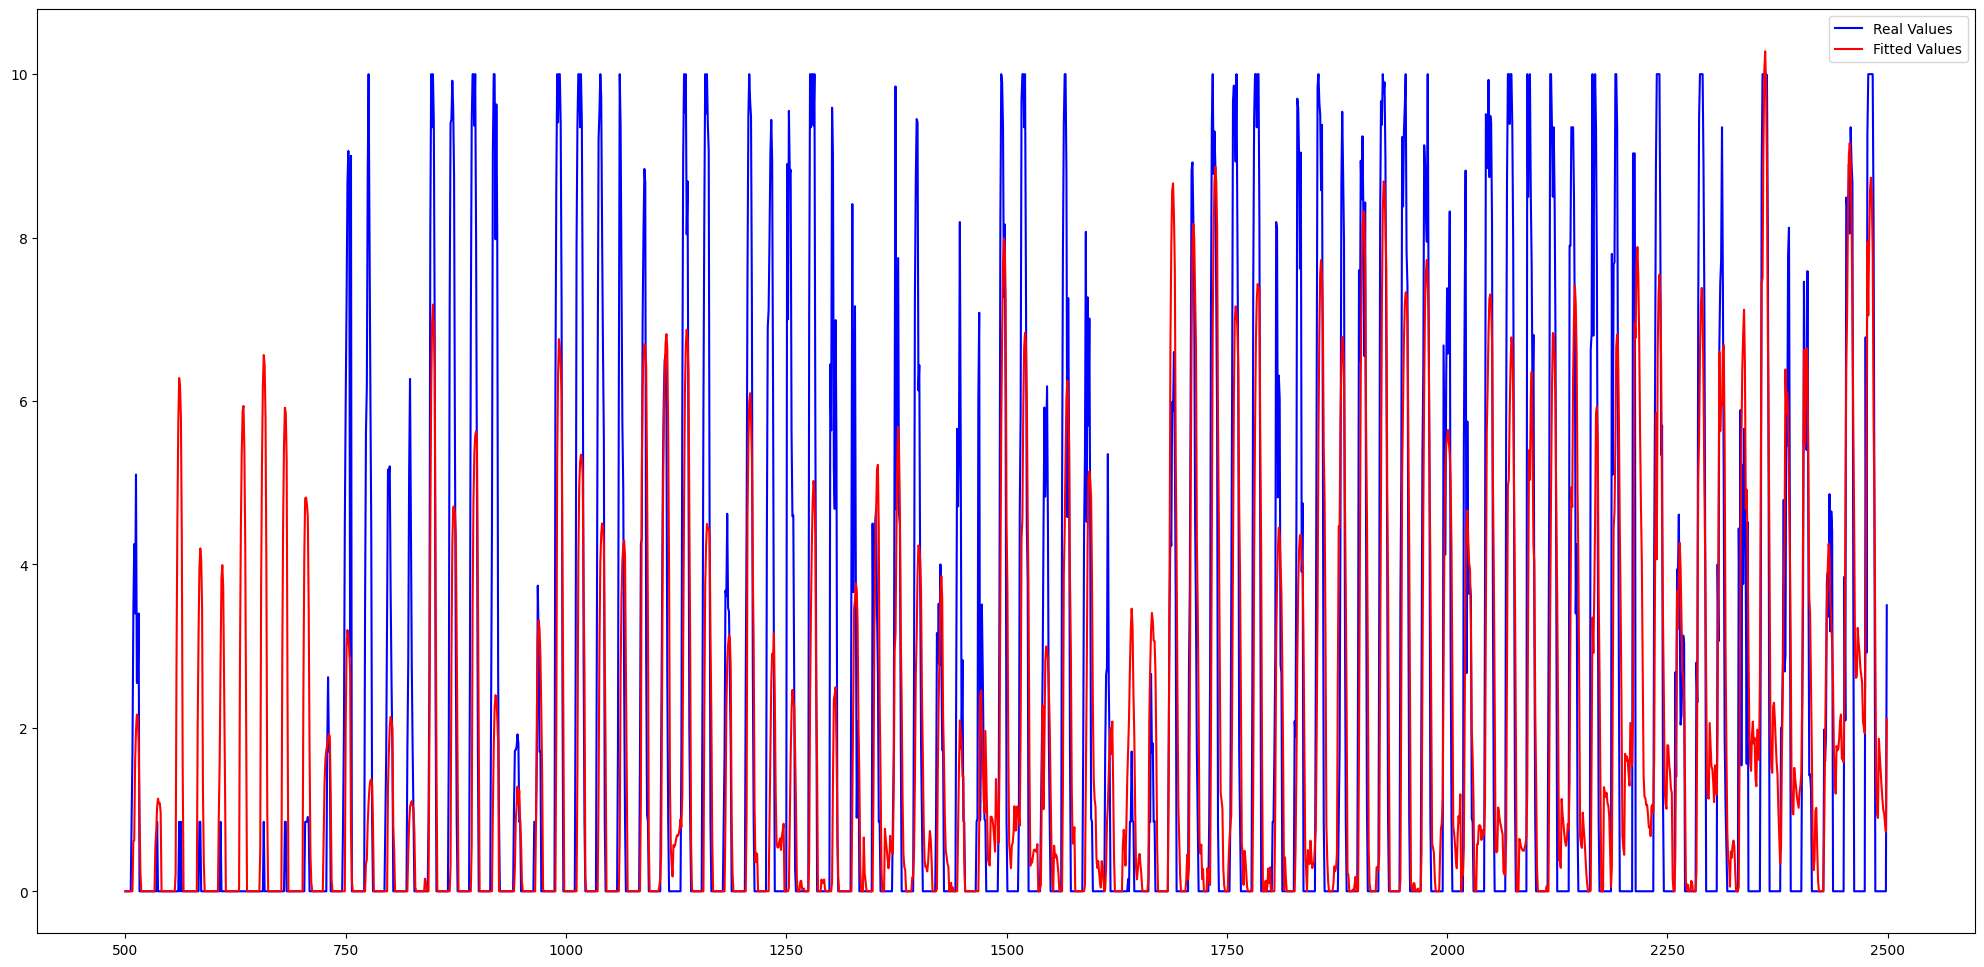

In [47]:
lasso_result = lasso.predict(features)
fitted = [max(0, i) for i in lasso_result]

plt.figure(figsize=(25, 12))
plt.plot(range(500, 2500), df["production"][500:2500], label="Real Values", color="blue")
plt.plot(range(500, 2500), fitted[500:2500], label="Fitted Values", color="red")
plt.legend(loc="best")
plt.show()

# Combined Model

In [48]:
df_combined = pd.DataFrame(data = [lasso_result, forecasted_values])
df_combined = df_combined.T
df_combined.columns = ['Lasso', 'Arima']
df_combined = sm.add_constant(df_combined)

df_combined

,const,Lasso,Arima
0,1.0,-0.390266,0.000000e+00
1,1.0,-0.352648,0.000000e+00
2,1.0,-0.366225,0.000000e+00
3,1.0,-0.333578,0.000000e+00
4,1.0,-0.298952,3.400000e+00
...,...,...,...
20943,1.0,-0.616198,0.000000e+00
20944,1.0,-1.503300,1.252205e-16
20945,1.0,-1.530351,0.000000e+00
20946,1.0,-0.194933,0.000000e+00


In [49]:
lm = sm.OLS(df["production"], df_combined)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 6.582e+04
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:05:20   Log-Likelihood:                -36131.
No. Observations:               20948   AIC:                         7.227e+04
Df Residuals:                   20945   BIC:                         7.229e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0499      0.012     -3.998      0.0

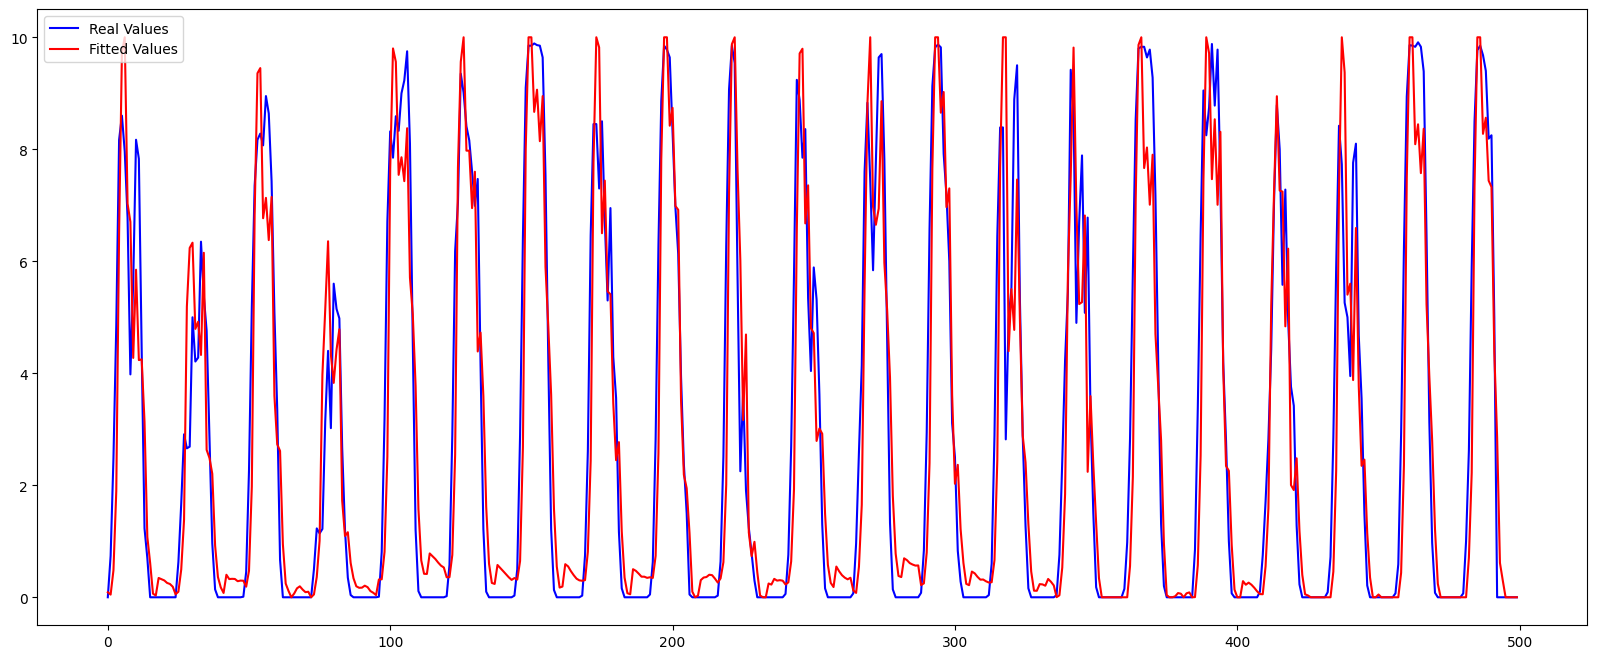

In [50]:
fitted = [max(0, i) for i in result.fittedvalues]
fitted = [min(10, i) for i in fitted]

plt.figure(figsize=(20, 8))
plt.plot(range(0, 500), df["production"][-500:], label="Real Values", color="blue")
plt.plot(range(0, 500), fitted[-500:], label="Fitted Values", color="red")
plt.legend(loc="best")
plt.show()

<Axes: title={'center': 'Residuals'}, ylabel='Density'>

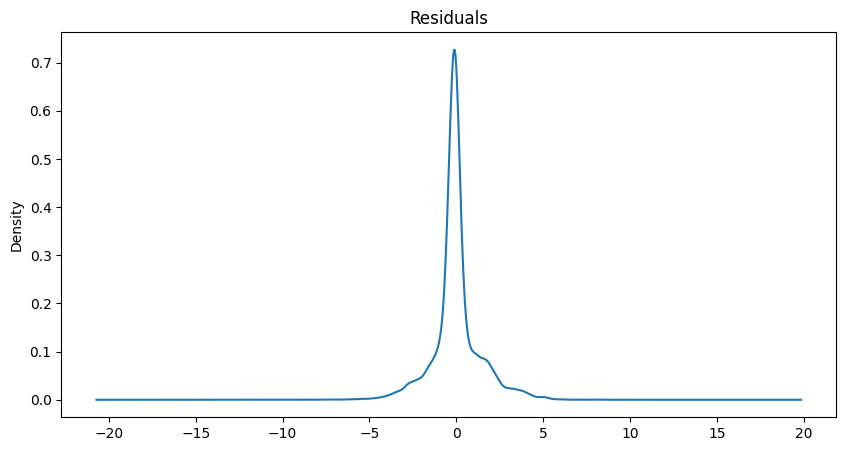

In [51]:
result.resid.plot(kind="kde", title="Residuals", figsize=(10, 5))

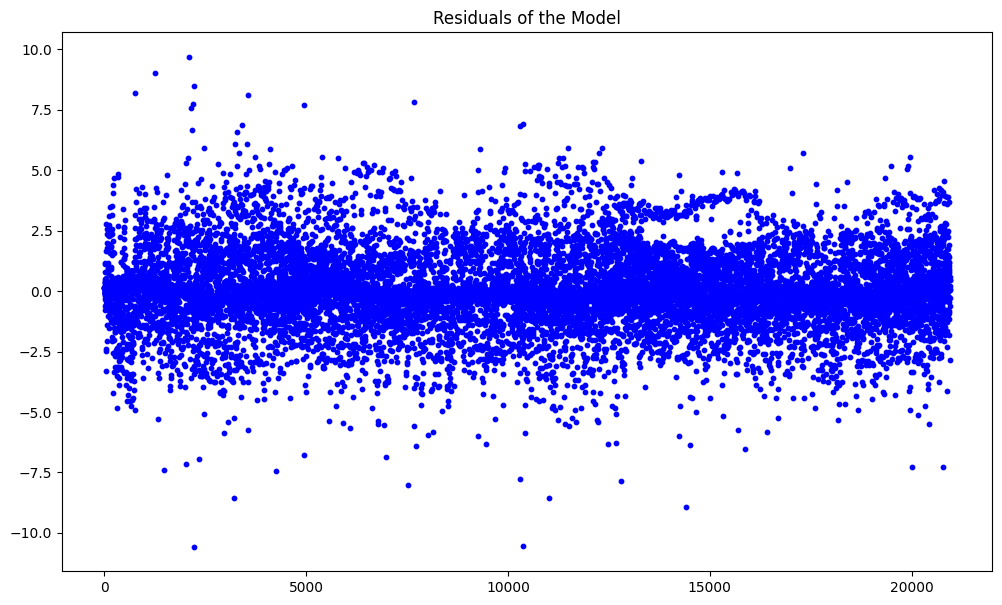

In [52]:
residual = result.resid

plt.figure(figsize = (12, 7))
plt.scatter(range(len(df)),residual, label = "Residual", color = "blue", s = 10)
plt.title("Residuals of the Model")

plt.show()

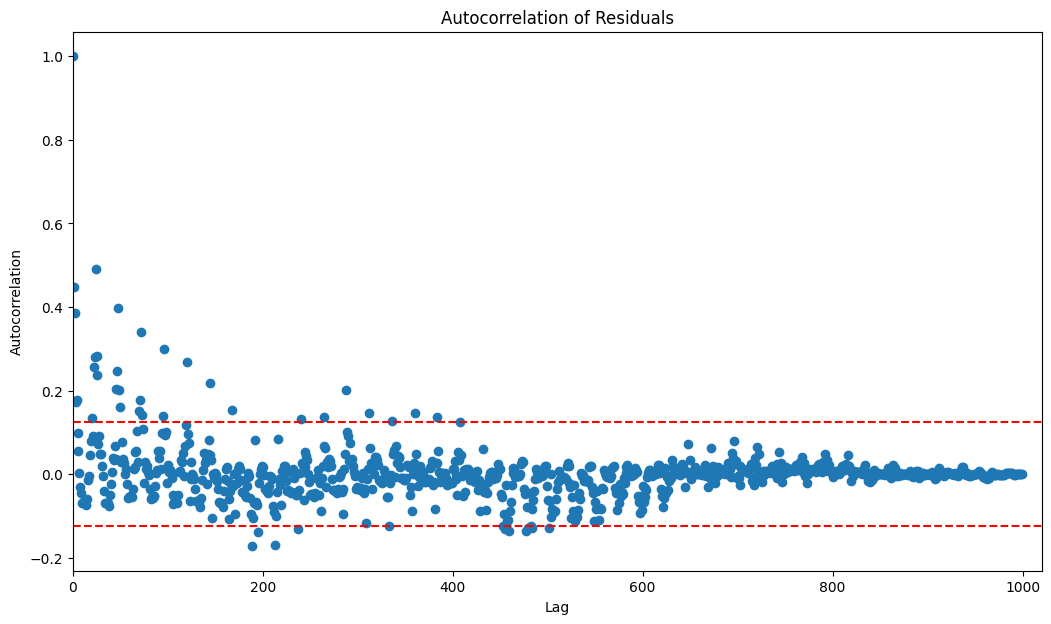

In [53]:
plt.figure(figsize=(12.5, 7))  
plt.acorr(result.resid[:1000], maxlags=len(result.resid[:1000])-1, usevlines = False, marker='o')
plt.axhline(y=0.125, color='red', linestyle='--') 
plt.axhline(y=-0.125, color='red', linestyle='--') 
plt.title("Autocorrelation of Residuals")
plt.xlim(0, 1020)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

# Prediction

In [54]:
cut_off_date = production_df["date"].iloc[-1]

next_day = cut_off_date + timedelta(days=3)

result_df = predict_df[predict_df["date"] == next_day]
features = result_df.copy()
features.drop(columns=["date", "hour"], inplace=True)
lst = weather_df.columns[4:-10]

for feature in lst:
    feature_col = result_df.columns[result_df.columns.str.contains(feature)]
    features[f"max_{feature}"] = result_df[feature_col].max(axis=1)
    features[f"min_{feature}"] = result_df[feature_col].min(axis=1)
    features[f"mean_{feature}"] = result_df[feature_col].mean(axis=1)
    features[f"sum_{feature}"] = result_df[feature_col].sum(axis=1)
    features[f"median_{feature}"] = result_df[feature_col].median(axis=1)
    features[f"std_{feature}"] = result_df[feature_col].std(axis=1)
    features[f"var_{feature}"] = result_df[feature_col].var(axis=1)
    features[f"range_{feature}"] = result_df[feature_col].max(axis=1) - result_df[feature_col].min(axis=1)

lasso_pred = lasso.predict(features)

In [55]:
arima_res = best_arima.predict(n_periods = 24)
last_24_hours = production_df[-24:]

arima_pred = [last_24_hours["production"].iloc[i] + arima_res[i] for i in range(len(arima_res))]

In [56]:
df_combined = pd.DataFrame(data = [lasso_pred, arima_pred])
df_combined = df_combined.T
df_combined.columns = ['Lasso', 'Arima']
df_combined = sm.add_constant(df_combined)

In [57]:
prediction = result.predict(df_combined)
prediction = [max(0, i) for i in prediction]
prediction = [min(10, i) for i in prediction]
prediction = [round(i,2) for i in prediction]

In [58]:
final_pred = [0] * 5 + prediction[5:16] + [0] * 8
formatted_list = ",".join(map(str, final_pred))

print(next_day)
print("\n")
print(formatted_list)

2024-05-26 00:00:00


0,0,0,0,0,0.68,2.22,5.52,8.19,9.76,9.42,9.44,9.12,7.97,7.87,5.21,0,0,0,0,0,0,0,0
